<a href="https://colab.research.google.com/github/aminakhshi/hints/blob/main/examples/Lorenz_96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High-Order Interactions: The Lorenz 96 Model

The Lorenz 96 model, introduced by Edward Lorenz in 1996, serves as a framework for understanding atmospheric dynamics and chaos theory. Unlike its predecessor, the original Lorenz system that models convection rolls in the atmosphere, the Lorenz 96 model is designed to simulate the behavior of a single atmospheric variable over a range of spatial positions along a latitude circle. It consists of a set of N coupled ordinary differential equations, where each equation represents the evolution of a single state variable. The model is given by:

\begin{equation}
\frac{dx_j}{dt} = (x_{j+1} - x_{j-2})x_{j-1} - x_j + F
\end{equation}

where j=1,...,N, and the indices are taken modulo N. The parameter F represents the forcing term, which is a constant that drives the system.

The Lorenz 96 model is a simplified version of the atmospheric dynamics, but it captures the essential features of the atmosphere, such as the presence of waves and the emergence of chaotic behavior.

In this tutorial, we will use the Lorenz 96 model to illustrate the estimation of interactions between different state variables. We will use the package [HiNTS](https://hints.readthedocs.io/en/latest/) to obtain the interactions between different state variables (j=1,..., 10) of the system. We will cover the implementation of the model, how to simulate its dynamics, and visualize the results through static and animated plots. Finally, we will use the K-Maximal Cliques Coefficients (KMCC) method to obtain the coefficients from the simulated timeseries data.

### References:

The model we discuss here is based on the foundational work of Edward Lorenz, who first introduced this model in his seminal paper:

- [1] Lorenz, E. (1996). Predictability – A problem partly solved. In *Proceedings of the Seminar on Predictability*, Vol. 1.

Further reading and references:

- [2] Akhshi, A., et al. (2024). HiNTS: Higher-Order Interactions in N-Dimensional Time Series. arXiv
- [3] Tabar, M.R.R., et al. (2024). Revealing Higher-Order Interactions in High-Dimensional Complex Systems: A Data-Driven Approach. *PRX*.
- [4] Lorenz, E. (1998). Optimal sites for supplementary weather observations: Simulation with a small model. *Journal of the Atmospheric Sciences*.

## Setup and Preliminaries

In order to run the simulations and visualize the results, we use `jitcsde` package to solve the stochastic Lorenz 96 model. All the necessary libraries can be installed using the following command:

In [ ]:
!pip install git+https://github.com/aminakhshi/hints.git

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
from jitcsde import jitcsde, y, t
from LS96SDE import *

In [ ]:
# Run the code below to access cloud data on Colab!
# from google.colab import auth
# auth.authenticate_user()

## The Lorenz 96 Model Class

In order to define and simulate the model, we define the `L96SDE` class in python to handle the deterministic `F(x,t)` and stochastic `G(x,t)` equations and handle the integration of the model using the `jitcsde` package. The class can be found in the `l96sde.py` file in the `examples` directory of the [HiNTS](https://github.com/aminakhshi/hints) package. Let's break down the code and understand the components of the class.

### Class Initialization

The L96SDE class initializes the Lorenz 96 model with a given number of variables (K), forcing constant (F), integration time step (dt), and noise standard deviation (sigma). Users can specify an initial state or let the model generate a random one.

```python
class L96SDE:
    def __init__(self, K, F, dt, sigma, x0=None):
        self.K = K
        self.F = F
        self.dt = dt
        self.sigma = sigma
        self.x0 = x0
        self.x = self.x0 if self.x0 is not None else np.random.rand(self.K)
```



### Deterministic and Stochastic Equations

`_define_model` in the class defines the **deterministic** equations `F(x,t)` of the standard Lorenz 96 model.

```python
    def _define_f(self):
        f_sym = [
            (-y((j-1) % self.K) * (y((j-2) % self.K) - y((j+1) % self.K)) - y(j) + self.F)
            for j in range(self.K)
            ]
        return f_sym
```



For simplicity, we assume that the **stochastic** equations `G(x,t)` is a Gaussian noise with a standard deviation of `sigma` for each variable. defined by the following equation:

```python
    def _define_g(self):
        g_sym = [self.sigma for _ in range(self.K)]
        return g_sym
```


## Integration of the Model

The `integrate` method in the class integrates the model using the `jitcsde` package. The method takes the number of time steps `n_steps` and the integration method `method` as input arguments, and returns the simulated timeseries data of the model.

```python
    def iterate(self, time):
        f_sym = self._define_f()
        g_sym = self._define_g()
        SDE = jitcsde(f_sym=f_sym, g_sym=g_sym, n=self.K, additive=self.additive)
        SDE.set_initial_value(initial_value=self.X0, time=0.0)
        SDE.set_seed(seed=self.seed)
        
        steps = int(time / self.dt)
        for _ in tqdm(range(steps), disable=self.noprog):
            self.X0 = SDE.integrate(SDE.t + self.dt)
            self.X.append(self.X0.copy())
```

Now, that we defined the model, we can simulate the dynamics of stochastic Lorenz 96 model and visualize the evolution of the state variables over time. Using the code below, the `L96SDE` class stores the simulated timeseries data in `model.X` and we visulize the result using plot functions. The default parameters we use are `K=10`, `F=8`, `dt=0.01`, and `sigma=0.1`.

In [ ]:
model = L96SDE()
model.iterate(10000.0)

  0%|          | 0/1000000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


  1%|          | 5397/1000000 [00:01<02:12, 7532.65it/s]

Using default integration parameters.


100%|██████████| 1000000/1000000 [00:37<00:00, 26733.23it/s]


### Visualization

To visualize the simulated timeseries, have the choice to plot the state variables over time, or using polar coordinates to visualize the evolution of the state variables over time.

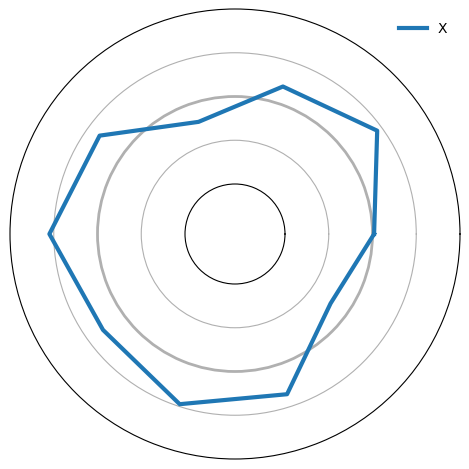

In [ ]:
# This plot show the last time step of the model in polar coordinates
model.static_plot()

In order to visualize the model's evolution over time, we need to create an animation. Please note that viewing the animation in a Jupyter notebook may need additional setup.

In [ ]:
from IPython.display import HTML
ani = model.animate_plot(total_frames=50)
HTML(ani.to_jshtml())

To show the model evolution in time, we can also show the state variables in Cartesian coordinates. The following function illustrates the model's evolution over time for the first 3000 time steps.

In [ ]:
def ts_plot(data, time=None, **kwargs):
    data = np.atleast_2d(data)
    if data.shape[0] > data.shape[1]:
        data = data.T
    ndim = data.shape[0]
    time = time if time is not None else np.arange(data.shape[1])
    save_plot = kwargs.pop('save_plot', False)
    if save_plot:
        save_path = kwargs.pop('save_path', os.getcwd())
    filename = kwargs.pop('filename', 'timeseries.pdf')
    style_path = kwargs.pop('style', 'seaborn-v0_8-talk')
    plt.style.use(style_path)
    ncols = 1 if ndim < 5 else 2
    nrows = ndim if ncols == 1 else -(-ndim // ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 3*nrows),
                            sharex=True, constrained_layout=True)

    # Ensure axs is 2D for uniform handling
    axs = np.atleast_2d(axs)
    for i, dat in enumerate(data):
        ax = axs.flat[i]
        ax.plot(time, dat, **kwargs)
        ax.set_ylabel(f'$x_{{{i+1}}}$')
        if i // ncols != nrows - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('time')

        ax.autoscale(enable=True, axis='x', tight=True)
        ax.autoscale(enable=True, axis='y', tight=False)

    # Removing empty subplot if odd number of subplots
    if ndim % ncols != 0:  # Remove unused axes for odd number of plots
        for idx in range(ndim, nrows*ncols):
            fig.delaxes(axs.flat[idx])

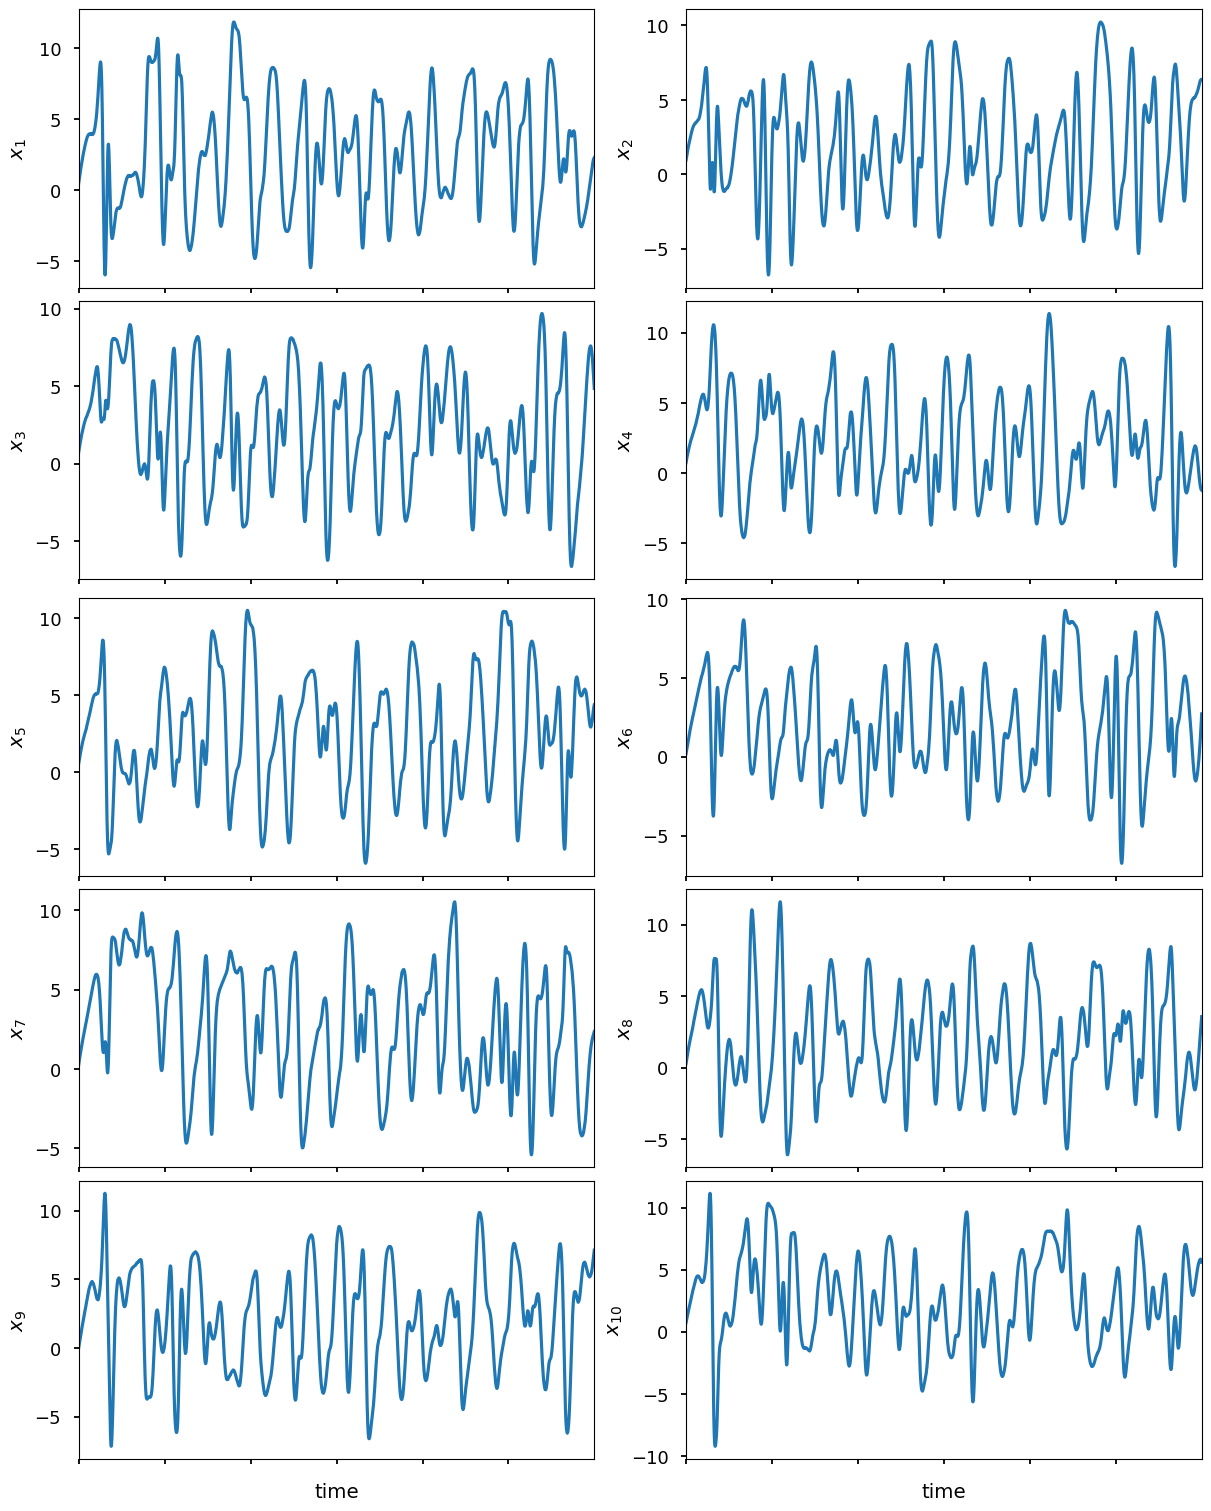

In [ ]:
ts_plot(model._history[:3000])

Finally, to show the chaotic behavior of the Lorenz 96 model, we can visualize the first three state variables in 3D space.

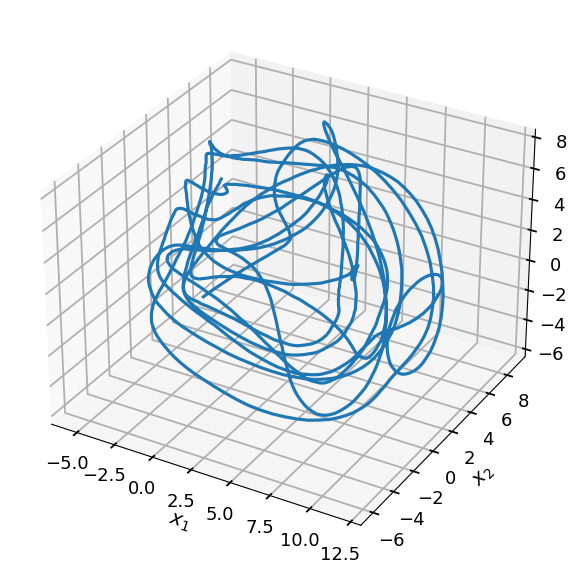

In [ ]:
with plt.style.context('seaborn-v0_8-talk'):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot(model._history[500:2000, 0], model._history[500:2000, 1], model._history[500:2000, 2])
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_zlabel("$x_3$")
    # plt.savefig(os.path.join(os.getcwd(), 'timeseries3d.pdf'), bbox_inches='tight')
    # plt.close()

## Estimation of Interactions

Now that we have simulated the Lorenz 96 model, we can use the simulated timeseries data to estimate the interactions between different state variables. We will use the Kramers-Moyal Coefficients calculator (KMCC) method to obtain the coefficients from the simulated timeseries data. The KMCC method is a data-driven approach that can reveal higher-order interactions in high-dimensional complex systems ([Tabar et al. (2024)](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.14.011050)\). The method is implemented in the `HiNTS` package, and we can use the `KMCC` class to estimate these interactions.

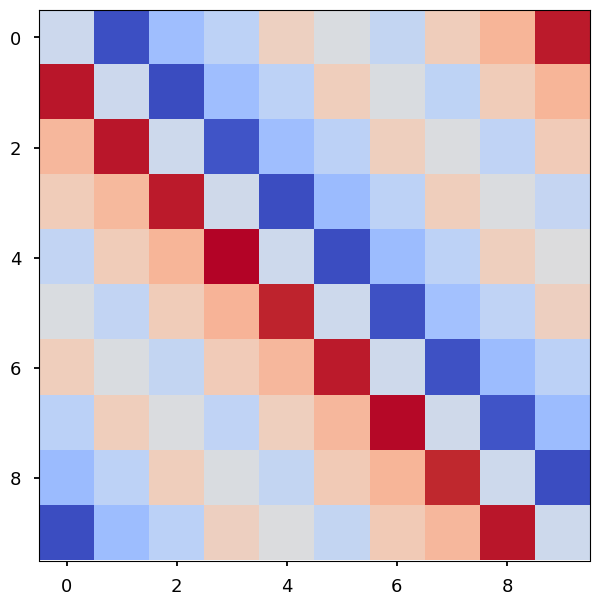

In [ ]:
import hints

calulator = hints.kmcc(ts_array=model._history, dt=model.dt, interaction_order=[0,1],
                       estimation_mode='drift')
coeffs = calulator.get_coefficients()
plt.figure()
plt.imshow(coeffs.values[1:11,:], cmap='coolwarm')